# Assignment

In this assignment, we will create a token embedding for polyseme resolution. We will use the dataset [CoarseWSD-20](https://github.com/danlou/bert-disambiguation/tree/master/data/CoarseWSD-20).

Complete the following tasks and upload your notebook to your GitHub repository.

1. Fill in the black functions, marked by, "\#TODO", in the notebook
2. Update this notebook by using `git add`, `git commit`, and then `git push`.
3. The notebook will be automatically graded, and your score will be shown on GitHub. See [how to check the results on GitHub](https://docs.github.com/en/education/manage-coursework-with-github-classroom/learn-with-github-classroom/view-autograding-results)

Dont's:
- Do not import any libraries except for the ones that are already imported. The grading script will not work if you import additional libraries.
- Do not change the name of the functions. The grading script will not work if you change the name of the functions.
- DO not remove the cells with tag "gradable". If you happen to remove the cells with tag "gradable", recreate the cell and add the tag "gradable" to the cell.

Do's:
- Make the code clearn and easy to understand. Consider using linters & formatters such as `black`. [Youtube: Linters and fixers: never worry about code formatting again (Vim + Ale + Flake8 & Black for Python) by Yong-Yeol Ahn](https://www.youtube.com/watch?v=4FKPySR6HLk)
- You can add additional cells as you like. If you want to include the additional cells in the grading, you need to add the tag "gradable" to the cell. Otherwise, your additional cells will be stripped out when grading. 

In [82]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch

def load_data(focal_word, is_train, n_samples=100):
    data_type = "train" if is_train else "test"
    data_file = f"https://raw.githubusercontent.com/danlou/bert-disambiguation/master/data/CoarseWSD-20/{focal_word}/{data_type}.data.txt"
    label_file = f"https://raw.githubusercontent.com/danlou/bert-disambiguation/master/data/CoarseWSD-20/{focal_word}/{data_type}.gold.txt"

    data_table = pd.read_csv(
        data_file,
        sep="\t",
        header=None,
        dtype={"word_pos": int, "sentence": str},
        names=["word_pos", "sentence"],
    )
    label_table = pd.read_csv(
        label_file,
        sep="\t",
        header=None,
        dtype={"label": int},
        names=["label"],
    )
    combined_table = pd.concat([data_table, label_table], axis=1)
    return combined_table.sample(n_samples)

# Polyseme resolution using BERT



Let us consider a case study of polysemy resolution.
Consider the following two sentences:
- "The bank in the city is closed"
- "The bank in the river is closed"

The word "bank" has two meanings:
- "bank" as in "financial institution"
- "bank" as in "side of a river"

To resolve the polysemy, we can use BERT to get the embeddings of the sentence and the word "bank".

In [83]:
focal_word = "java"

train_data = load_data(focal_word, is_train=True)
train_data.head()

,word_pos,sentence,label
1854,12,acrocercops euargyra is a moth of the gracilla...,0
4225,9,"later , disaffected smiths and noble entourage...",0
874,10,plot a suicide bombing has occurred at a party...,0
355,10,"in 1929 , he participated in an academic trip ...",0
1558,5,the islands of sumatra and java in western ind...,0


The data contains word_pos, label, and sentence. The word_pos indicates the token in question for polysemy resolution. The label indicates the meaning of the token in the sentence.

Using BERT, we generate an embedding for each token in the sentence. Here is how we can do it:

In [84]:
# Import transformers
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased"
)

# Load the model
model = AutoModel.from_pretrained(
    "bert-base-uncased"
)

# Set the model to evaluation mode
model = model.eval()

In [85]:
test_sentence = train_data["sentence"].values[0]

encoded_inputs = tokenizer(
    test_sentence,
    padding=True,
    truncation=True,
    return_tensors="pt",
    add_special_tokens=True
)

# Get the embeddings of the tokens
outputs = model(**encoded_inputs, output_hidden_states=True)

The `outputs` contains the embeddings of the tokens. The `outputs.hidden_states` contains the embeddings of the tokens in all layers.

In [86]:
print("Number of layers:", len(outputs.hidden_states))
print("Shape of the embeddings:", outputs.hidden_states[0].shape)


Number of layers: 13
Shape of the embeddings: torch.Size([1, 29, 768])


where the first dimension is the batch size, the second dimension is the sequence length, and the third dimension is the embedding dimension. 
Now, let's extract the embedding of the token in question.

In [87]:
word_pos = train_data["word_pos"].values[0]
token_embedding = outputs.hidden_states[0][0, word_pos]

print("Shape of the token embedding:", token_embedding.shape)

Shape of the token embedding: torch.Size([768])


Conveniently, you can get the embedding in batch mode: 

In [88]:
test_sentences = train_data["sentence"].values.tolist()

encoded_inputs = tokenizer(
    test_sentences,
    padding=True,
    truncation=True,
    return_tensors="pt",
    add_special_tokens=True
)

# Get the embeddings of the tokens
outputs = model(**encoded_inputs, output_hidden_states=True)

In [89]:
print("Shape of the embeddings:", outputs.hidden_states[0].shape)

Shape of the embeddings: torch.Size([100, 186, 768])


Where the 100 is the batch size (e.g., number of sentences).

Now, we have the embedding of the token in question. Let's visualize the embedding using PCA. We will focus on the first layer.


In [90]:
import torch

# TODO
def get_token_embedding(sentences, word_pos, model, tokenizer):
    """
    Generate the embedding of the token in question.

    Parameters:
        sentences: The sentences to generate the embedding. Must be a list of strings.
        word_pos: The position of the focal token in the sentence. Must be a numpy array or list of integers.

    Returns:
        The embedding of the token in question.
    """

    encoded_inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=True
    )

    outputs = model(**encoded_inputs, output_hidden_states=True)

    emb = []
    for i, (sentence, word_pos) in enumerate(tuple(zip(sentences, word_pos))):
        token_embedding = outputs.hidden_states[0][i, word_pos]
        emb.append(token_embedding.detach().numpy())
    return np.array(emb)

In [91]:
emb = get_token_embedding(train_data["sentence"].values, train_data["word_pos"].values, model, tokenizer)

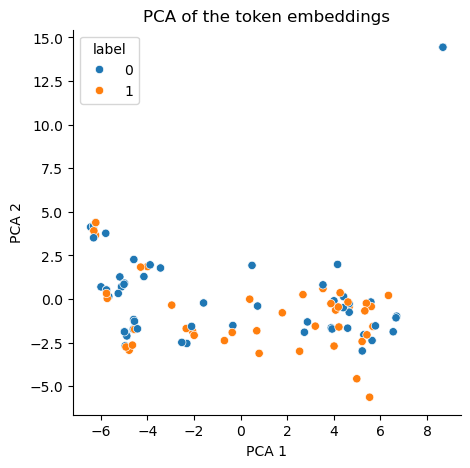

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(emb)
emb_pca = pca.transform(emb)

df = pd.DataFrame(emb_pca, columns=["pca_x", "pca_y"])
df["label"] = train_data["label"].values

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="pca_x", y="pca_y", hue="label", data=df, ax=ax)
ax.set_title("PCA of the token embeddings")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
sns.despine()

In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_classifier(emb, labels):
    """
    Train a classifier on the embeddings.
    """
    clf = LinearDiscriminantAnalysis(n_components=1)
    clf.fit(emb, labels)
    return clf

clf = train_classifier(emb, train_data["label"].values)

prediction = clf.predict(emb)

Let's evaluate the performance of the classifier using the classification accuracy. 

In [94]:
def evaluate_classifier(clf, emb, labels):
    """
    Evaluate the performance of the classifier.
    """
    prediction = clf.predict(emb)
    accuracy = np.mean(prediction == labels)
    return accuracy
accuracy = evaluate_classifier(clf, emb, train_data["label"].values)
accuracy

0.96

Fof the test set, 

In [95]:
import torch

train_data = load_data(focal_word, is_train=True)
test_data = load_data(focal_word, is_train=False)

# Get the embeddings of the test set
emb_train = get_token_embedding(train_data["sentence"].values, train_data["word_pos"].values, model, tokenizer)

# Get the embeddings of the test set
emb_test = get_token_embedding(test_data["sentence"].values, test_data["word_pos"].values, model, tokenizer)

# Train the classifier
clf = train_classifier(emb_train, train_data["label"].values)

# Get the predictions
prediction = clf.predict(emb_test)

# Evaluate the performance
accuracy = evaluate_classifier(clf, emb_test, test_data["label"].values)
accuracy



0.45

# Task: 

Modify the `get_token_embedding` function to improve the performance of the classifier. You may use any layer of the BERT model. Your accuracy must be greater than 0.91.